In [1]:
%load_ext autoreload
%autoreload 2

import logging
import gradio as gr

from agent.agents import (
    create_one_action_agent_executor,
    stream_agent_output,
    StateCapture
)
from config.utils import setup_logging, get_logger
from config.config import ConfigManager

# checking where we are
!pwd

/Users/eliza/search-pydantic-ai/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/Users/eliza/search-pydantic-ai


## Config and logging

In [6]:
setup_logging(level=logging.INFO)
logger = get_logger(__name__)
logger.warning("Starting the application...")
logger.info("Starting the application...")
config = ConfigManager()

print(config.documentation_urls)
print(config.config['embed_with_openai'])

2025-05-14 17:02:38,047 - __main__ - WARNING - Starting the application...
2025-05-14 17:02:38,049 - __main__ - INFO - Starting the application...
2025-05-14 17:02:38,050 - config.config - INFO - Attempting to load configuration from config.json
2025-05-14 17:02:38,053 - config.config - INFO - Configuration loaded successfully.
2025-05-14 17:02:38,055 - config.config - INFO - Configuration validated.
['https://ai.pydantic.dev/']
True


## Multiquery and follow up agent interface
**Scroll down for gradio interfaces**

**Gradio interfaces isn't visible on Github**

In [119]:
import gradio as gr
from agent.agents import (
    create_multi_query_agent_executor, 
    stream_agent_output,
    StateCapture
)

state_capture = StateCapture()
agent_executor = create_multi_query_agent_executor()

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(height=320)
    # Text input with stop button on right
    with gr.Row():
        with gr.Column(scale=20):
            msg = gr.Textbox(label="Message", placeholder="Ask something...")
            
        with gr.Column(scale=1, min_width=40):
            stop_btn = gr.Button("⏹️", size="sm", variant="stop")
    
    # Buttons below the text input        
    with gr.Row():
        send_btn = gr.Button("Send", size="md", variant="primary", scale=3)
        clear = gr.Button("Clear", size="md", scale=1)
    
    def respond(message, chat_history):
        # Add user message to chat history
        chat_history.append((message, ""))
        yield chat_history
        
        # Message tracking variables
        bot_message = ""
        current_mode = "normal"  # Tracking if we're in a "searching" or "normal" mode
        searching_complete = False  # Track if we've seen a searching message
        
        # Stream the agent's response
        for chunk in stream_agent_output(agent_executor, message, state_capture):
            # Detect message type transitions
            if chunk.startswith("Searching:"):
                # We're in searching mode
                if current_mode == "normal" and bot_message:
                    # If we already had normal content, separate it
                    bot_message += "\n\n---\n\n"
                
                current_mode = "searching"
                searching_complete = True
                bot_message += chunk
                
            else:
                # We're in normal response mode
                if current_mode == "searching" and searching_complete:
                    # Transition from searching to normal - add separator
                    bot_message += "\n\n---\n\n"
                    current_mode = "normal"
                    
                # Add content to current message
                bot_message += chunk
                
            # Update chat history with formatted message
            chat_history[-1] = (message, bot_message)
            yield chat_history

    
    # Set up events with cancellation
    msg_event = msg.submit(respond, [msg, chatbot], [chatbot])
    send_event = send_btn.click(respond, [msg, chatbot], [chatbot])
    
    # Clear button
    clear.click(lambda: None, None, chatbot, queue=False)
    
    # Stop button cancels both the message submit and send button events
    stop_btn.click(fn=None, inputs=None, outputs=None, cancels=[msg_event, send_event])

demo.launch(inline=True, share=False)

/var/folders/3n/7m69d59d44x4c5xxm3gwg9880000gn/T/ipykernel_93576/1468504269.py:12: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=320)


* Running on local URL:  http://127.0.0.1:7863
2025-05-16 08:55:12,637 - httpx - INFO - HTTP Request: GET http://127.0.0.1:7863/gradio_api/startup-events "HTTP/1.1 200 OK"
2025-05-16 08:55:12,653 - httpx - INFO - HTTP Request: HEAD http://127.0.0.1:7863/ "HTTP/1.1 200 OK"
* To create a public link, set `share=True` in `launch()`.


2025-05-16 08:55:13,316 - httpx - INFO - HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"


## Check evaluations

In [78]:
# ids of human and AI evaluated runs
evaluated_runs = [
    "d9cbcee4-dc82-4da4-acc7-0f376be2e889"
    ,"5baa2d04-f373-4a7e-aebc-0896b80ee8fb"
    ,"278aae49-2f67-4f81-b75e-1d85d9598fb3"
    ,"19a389a0-9324-4323-98d2-b9284b002917"
    ,"3bd61ae7-8125-439b-a68d-7cc95822c5d1"
    ,"3fd145d8-0614-4e92-901a-7fcd5460fbb6"
    ,"ce0688e5-c724-4154-84fe-c89daeb2fd4e"
    ,"8518e0c4-1c61-4ddd-be84-25df5f2bbcdb"
    ,"f7300475-0602-41e4-98fd-c8533dc43724"
    ,"6f035a84-8c63-4de6-bc1f-b3f96de00c03"
    ,"33b3b45e-51a0-4cb1-b214-bfeef1a53d4b"
    ,"00e24866-0240-4bdb-b049-38cc0fbe2cc2"
    ,"5d1475f0-2cab-453f-9205-22a83b2ab418"
    ,"d512c56b-6b55-4d4e-b834-7f0dac864d9d"
    ,"c4702f3d-37fd-427e-bc0a-3403b09608fa"
    ,"726f9ec9-3ef0-4454-b67d-8b235fc01108"
    ,"2a15a4f1-2a90-4b6b-8a83-7bc89cf4d82e"
    ,"75dd7fbc-6b41-49bb-ba38-9afac4dcb1e1"
    ,"4cc01bb1-def2-4f29-a717-d79c50a23f90"
    ,"8963e97f-111e-4fe9-bc7f-fc79ef88d982"
    ]

In [89]:
# getting feebacks from LangSmith is more difficult than it should be

from langsmith import Client
import os
from uuid import UUID
from numpy import mean, std
from datetime import datetime, timedelta
from dotenv import load_dotenv

load_dotenv()

client = Client(api_key=os.getenv("LANGSMITH_API_KEY"))
runs =client.list_runs(
    project_name=os.getenv("LANGSMITH_PROJECT"),
    run_type="chain",
    start_time=datetime.now() - timedelta(days=2),
)

all_runs = [run for run in runs]
langgraph_runs = [run for run in all_runs if run.name == "LangGraph"]

evaluated_lr_runs = [
    lr for lr in langgraph_runs if str(lr.id) in evaluated_runs
]
all_feedbacks = []
for eval_run in evaluated_lr_runs:
    feedbacks = list(client.list_feedback(run_ids=eval_run.child_run_ids))
    all_feedbacks.extend(feedbacks)

# The most important metrics ranked by an AI Judge

## Answer Score (answered in full)

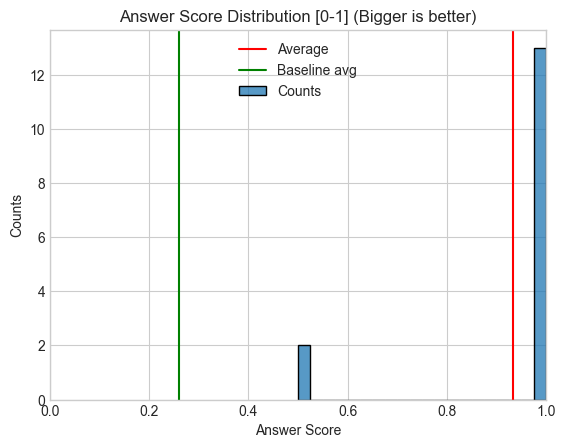

In [114]:
import matplotlib.pyplot as plt
import seaborn as sns
answer_scores = [feedback.score for feedback in all_feedbacks if feedback.key == "answer_score" and feedback.score is not None]
sns.histplot(answer_scores, bins=20, label="Counts")
plt.axvline(mean(answer_scores), color="red", label="Average")
plt.axvline(0.26, color="green", label="Baseline avg")
plt.title("Answer Score Distribution [0-1] (Bigger is better)")
plt.xlabel("Answer Score")
plt.ylabel("Counts")
plt.xlim(0, 1)
plt.legend();

## Expansion Score
- 0 -- completely adhering to the source
- 0.5 -- making *reasanoble* inferences
- 1 -- expanding beyond the source (unsupported claims)

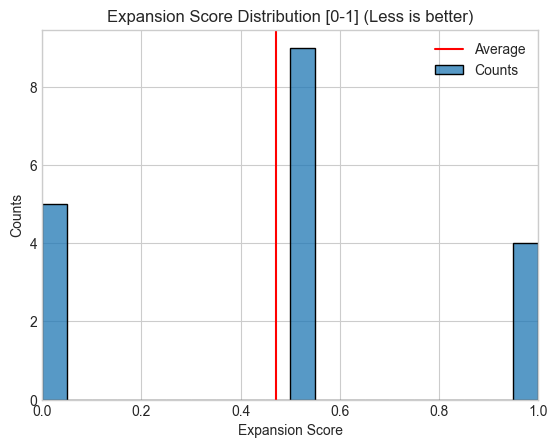

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns
answer_scores = [feedback.score for feedback in all_feedbacks if feedback.key == "expansion_score" and feedback.score is not None]
sns.histplot(answer_scores, bins=20, label="Counts")
plt.axvline(mean(answer_scores), color="red", label="Average")
plt.title("Expansion Score Distribution [0-1] (Less is better)")
plt.xlabel("Expansion Score")
plt.ylabel("Counts")
plt.xlim(0, 1)
plt.legend();

## No unnecessary info score (agent not being too helpful with extra information that user didn't ask for)

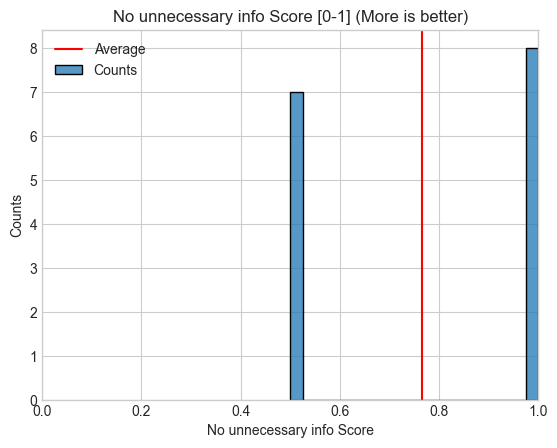

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
answer_scores = [feedback.score for feedback in all_feedbacks if feedback.key == "unnecessary_info_score" and feedback.score is not None]
sns.histplot(answer_scores, bins=20, label="Counts")
plt.axvline(mean(answer_scores), color="red", label="Average")
plt.title("No unnecessary info Score [0-1] (More is better)")
plt.xlabel("No unnecessary info Score")
plt.ylabel("Counts")
plt.xlim(0, 1)
plt.legend();